# Try to classify contigs as prokaryotic or eukaryotic just from an alignment

General idea: eukaryotic contigs, compared with prokaryotic contigs, should have relatively high amounts of positions with mutation frequencies around 50% (representing diploidy).

In [1]:
%run "Header.ipynb"
import os
import math
import json
import skbio
import pysam
import pysamstats
import pandas as pd
from statistics import mean
import pleuk.param_defaults as params
from pleuk.utils import get_seq2len
from pleuk.bam_utils import process_contig

## Load data: sheep gut contigs

This is obviously a very _ad hoc_ way of defining a file format. If this ever becomes a tool people use, it'd be a lot faster / more efficient to store this in a dedicated table structure!

These JSONs should already be filtered to edges with sufficient length and average coverage.

In [2]:
with open("../../prok-euk-analyses/output/pleuk_debug_info.txt", "r") as pef:
    edge2meancov = json.loads(pef.readline().strip())
    edge2num_wc_pos = json.loads(pef.readline().strip())
    edge2num_wc_diploid_pos = json.loads(pef.readline().strip())
    edge2num_wc_den_pos = json.loads(pef.readline().strip())
    
    print(f"{len(edge2meancov):,} edges in edge2meancov.")
    print(f"{len(edge2num_wc_pos):,} edges in edge2num_wc_pos.")
    print(f"{len(edge2num_wc_diploid_pos):,} edges in edge2num_wc_diploid_pos.")
    print(f"{len(edge2num_wc_den_pos):,} edges in edge2num_wc_den_pos.")

43,562 edges in edge2meancov.
12,099 edges in edge2num_wc_pos.
12,099 edges in edge2num_wc_diploid_pos.
12,099 edges in edge2num_wc_den_pos.


In [3]:
edge2len = get_seq2len("../../sheepgut/main-workflow/output/all_edges.fasta")
long_enough_seqs = [e for e in edge2len if edge2len[e] >= params.MIN_CONTIG_LEN]
print(f"{len(long_enough_seqs):,} edges with sufficient length.")

43,562 edges with sufficient length.


## Load data: contig from a human genome assembly

In [5]:
hbf = pysam.AlignmentFile("../../pleuk/misc-data/output/aln-sorted.bam", "rb")
human_contig_results = process_contig(
    "../../pleuk/misc-data/output/h1tg000001l.fasta",
    hbf,
    "h1tg000001l",
    101329166,
    params.MIN_AVG_COV,
    params.MIN_ALT_POS,
    params.WELL_COVERED_POS_DEVIATION,
    params.WELL_COVERED_POS_DEVIATION / 100,
    # The numerator / denominator stuff doesn't really matter here, since we're just extracting the
    # alt relfreqs. We thus keep them the same as the defaults for the sake of simplicity.
    params.MIN_NUMERATOR_ALT_RELFREQ / 100,
    params.MIN_DENOMINATOR_ALT_RELFREQ / 100,
    params.MAX_NUMERATOR_ALT_RELFREQ / 100,
    params.MAX_DENOMINATOR_ALT_RELFREQ / 100,
    False,
    params.PYSAM_MAX_DEPTH,
    verbose=True,
    extra_verbose=True,
    split_into_blocks=50000,
)

hbf.close()

Starting process_contig() for contig h1tg000001l (length 101,329,166 bp).
Contig has length 101,329,166 bp. Splitting into blocks of length 50,000 bp.
Since the contig length isn't divisible by the block length, the last 29,166 bp of this contig will be ignored.
Just processed position 100,000 / 101,329,166 (0.10%).
Just processed position 200,000 / 101,329,166 (0.20%).
Just processed position 300,000 / 101,329,166 (0.30%).
Just processed position 400,000 / 101,329,166 (0.39%).
Just processed position 500,000 / 101,329,166 (0.49%).
Just processed position 600,000 / 101,329,166 (0.59%).
Just processed position 700,000 / 101,329,166 (0.69%).
Just processed position 800,000 / 101,329,166 (0.79%).
Just processed position 900,000 / 101,329,166 (0.89%).
Just processed position 1,000,000 / 101,329,166 (0.99%).
Just processed position 1,100,000 / 101,329,166 (1.09%).
Just processed position 1,200,000 / 101,329,166 (1.18%).
Just processed position 1,300,000 / 101,329,166 (1.28%).
Just processed

Just processed position 14,000,000 / 101,329,166 (13.82%).
Just processed position 14,100,000 / 101,329,166 (13.92%).
Just processed position 14,200,000 / 101,329,166 (14.01%).
Just processed position 14,300,000 / 101,329,166 (14.11%).
Just processed position 14,400,000 / 101,329,166 (14.21%).
Just processed position 14,500,000 / 101,329,166 (14.31%).
Just processed position 14,600,000 / 101,329,166 (14.41%).
Just processed position 14,700,000 / 101,329,166 (14.51%).
Just processed position 14,800,000 / 101,329,166 (14.61%).
Just processed position 14,900,000 / 101,329,166 (14.70%).
Just processed position 15,000,000 / 101,329,166 (14.80%).
Just processed position 15,100,000 / 101,329,166 (14.90%).
Just processed position 15,200,000 / 101,329,166 (15.00%).
Just processed position 15,300,000 / 101,329,166 (15.10%).
Just processed position 15,400,000 / 101,329,166 (15.20%).
Just processed position 15,500,000 / 101,329,166 (15.30%).
Just processed position 15,600,000 / 101,329,166 (15.40%

Just processed position 27,900,000 / 101,329,166 (27.53%).
Just processed position 28,000,000 / 101,329,166 (27.63%).
Just processed position 28,100,000 / 101,329,166 (27.73%).
Just processed position 28,200,000 / 101,329,166 (27.83%).
Just processed position 28,300,000 / 101,329,166 (27.93%).
Just processed position 28,400,000 / 101,329,166 (28.03%).
Just processed position 28,500,000 / 101,329,166 (28.13%).
Just processed position 28,600,000 / 101,329,166 (28.22%).
Just processed position 28,700,000 / 101,329,166 (28.32%).
Just processed position 28,800,000 / 101,329,166 (28.42%).
Just processed position 28,900,000 / 101,329,166 (28.52%).
Just processed position 29,000,000 / 101,329,166 (28.62%).
Just processed position 29,100,000 / 101,329,166 (28.72%).
Just processed position 29,200,000 / 101,329,166 (28.82%).
Just processed position 29,300,000 / 101,329,166 (28.92%).
Just processed position 29,400,000 / 101,329,166 (29.01%).
Just processed position 29,500,000 / 101,329,166 (29.11%

Just processed position 41,800,000 / 101,329,166 (41.25%).
Just processed position 41,900,000 / 101,329,166 (41.35%).
Just processed position 42,000,000 / 101,329,166 (41.45%).
Just processed position 42,100,000 / 101,329,166 (41.55%).
Just processed position 42,200,000 / 101,329,166 (41.65%).
Just processed position 42,300,000 / 101,329,166 (41.75%).
Just processed position 42,400,000 / 101,329,166 (41.84%).
Just processed position 42,500,000 / 101,329,166 (41.94%).
Just processed position 42,600,000 / 101,329,166 (42.04%).
Just processed position 42,700,000 / 101,329,166 (42.14%).
Just processed position 42,800,000 / 101,329,166 (42.24%).
Just processed position 42,900,000 / 101,329,166 (42.34%).
Just processed position 43,000,000 / 101,329,166 (42.44%).
Just processed position 43,100,000 / 101,329,166 (42.53%).
Just processed position 43,200,000 / 101,329,166 (42.63%).
Just processed position 43,300,000 / 101,329,166 (42.73%).
Just processed position 43,400,000 / 101,329,166 (42.83%

Just processed position 55,700,000 / 101,329,166 (54.97%).
Just processed position 55,800,000 / 101,329,166 (55.07%).
Just processed position 55,900,000 / 101,329,166 (55.17%).
Just processed position 56,000,000 / 101,329,166 (55.27%).
Just processed position 56,100,000 / 101,329,166 (55.36%).
Just processed position 56,200,000 / 101,329,166 (55.46%).
Just processed position 56,300,000 / 101,329,166 (55.56%).
Just processed position 56,400,000 / 101,329,166 (55.66%).
Just processed position 56,500,000 / 101,329,166 (55.76%).
Just processed position 56,600,000 / 101,329,166 (55.86%).
Just processed position 56,700,000 / 101,329,166 (55.96%).
Just processed position 56,800,000 / 101,329,166 (56.05%).
Just processed position 56,900,000 / 101,329,166 (56.15%).
Just processed position 57,000,000 / 101,329,166 (56.25%).
Just processed position 57,100,000 / 101,329,166 (56.35%).
Just processed position 57,200,000 / 101,329,166 (56.45%).
Just processed position 57,300,000 / 101,329,166 (56.55%

Just processed position 69,600,000 / 101,329,166 (68.69%).
Just processed position 69,700,000 / 101,329,166 (68.79%).
Just processed position 69,800,000 / 101,329,166 (68.88%).
Just processed position 69,900,000 / 101,329,166 (68.98%).
Just processed position 70,000,000 / 101,329,166 (69.08%).
Just processed position 70,100,000 / 101,329,166 (69.18%).
Just processed position 70,200,000 / 101,329,166 (69.28%).
Just processed position 70,300,000 / 101,329,166 (69.38%).
Just processed position 70,400,000 / 101,329,166 (69.48%).
Just processed position 70,500,000 / 101,329,166 (69.58%).
Just processed position 70,600,000 / 101,329,166 (69.67%).
Just processed position 70,700,000 / 101,329,166 (69.77%).
Just processed position 70,800,000 / 101,329,166 (69.87%).
Just processed position 70,900,000 / 101,329,166 (69.97%).
Just processed position 71,000,000 / 101,329,166 (70.07%).
Just processed position 71,100,000 / 101,329,166 (70.17%).
Just processed position 71,200,000 / 101,329,166 (70.27%

Just processed position 83,500,000 / 101,329,166 (82.40%).
Just processed position 83,600,000 / 101,329,166 (82.50%).
Just processed position 83,700,000 / 101,329,166 (82.60%).
Just processed position 83,800,000 / 101,329,166 (82.70%).
Just processed position 83,900,000 / 101,329,166 (82.80%).
Just processed position 84,000,000 / 101,329,166 (82.90%).
Just processed position 84,100,000 / 101,329,166 (83.00%).
Just processed position 84,200,000 / 101,329,166 (83.10%).
Just processed position 84,300,000 / 101,329,166 (83.19%).
Just processed position 84,400,000 / 101,329,166 (83.29%).
Just processed position 84,500,000 / 101,329,166 (83.39%).
Just processed position 84,600,000 / 101,329,166 (83.49%).
Just processed position 84,700,000 / 101,329,166 (83.59%).
Just processed position 84,800,000 / 101,329,166 (83.69%).
Just processed position 84,900,000 / 101,329,166 (83.79%).
Just processed position 85,000,000 / 101,329,166 (83.89%).
Just processed position 85,100,000 / 101,329,166 (83.98%

Just processed position 97,400,000 / 101,329,166 (96.12%).
Just processed position 97,500,000 / 101,329,166 (96.22%).
Just processed position 97,600,000 / 101,329,166 (96.32%).
Just processed position 97,700,000 / 101,329,166 (96.42%).
Just processed position 97,800,000 / 101,329,166 (96.52%).
Just processed position 97,900,000 / 101,329,166 (96.62%).
Just processed position 98,000,000 / 101,329,166 (96.71%).
Just processed position 98,100,000 / 101,329,166 (96.81%).
Just processed position 98,200,000 / 101,329,166 (96.91%).
Just processed position 98,300,000 / 101,329,166 (97.01%).
Just processed position 98,400,000 / 101,329,166 (97.11%).
Just processed position 98,500,000 / 101,329,166 (97.21%).
Just processed position 98,600,000 / 101,329,166 (97.31%).
Just processed position 98,700,000 / 101,329,166 (97.41%).
Just processed position 98,800,000 / 101,329,166 (97.50%).
Just processed position 98,900,000 / 101,329,166 (97.60%).
Just processed position 99,000,000 / 101,329,166 (97.70%

    Just finished block #81 of 50,000 bp.
    Creating another block...
    Just finished block #82 of 50,000 bp.
    Creating another block...
    Just finished block #83 of 50,000 bp.
    Creating another block...
    Just finished block #84 of 50,000 bp.
    Creating another block...
    Just finished block #85 of 50,000 bp.
    Creating another block...
    Just finished block #86 of 50,000 bp.
    Creating another block...
    Just finished block #87 of 50,000 bp.
    Creating another block...
    Just finished block #88 of 50,000 bp.
    Creating another block...
    Just finished block #89 of 50,000 bp.
    Creating another block...
    Just finished block #90 of 50,000 bp.
    Creating another block...
    Just finished block #91 of 50,000 bp.
    Creating another block...
    Just finished block #92 of 50,000 bp.
    Creating another block...
    Just finished block #93 of 50,000 bp.
    Creating another block...
    Just finished block #94 of 50,000 bp.
    Creating another b

    Just finished block #204 of 50,000 bp.
    Creating another block...
    Just finished block #205 of 50,000 bp.
    Creating another block...
    Just finished block #206 of 50,000 bp.
    Creating another block...
    Just finished block #207 of 50,000 bp.
    Creating another block...
    Just finished block #208 of 50,000 bp.
    Creating another block...
    Just finished block #209 of 50,000 bp.
    Creating another block...
    Just finished block #210 of 50,000 bp.
    Creating another block...
    Just finished block #211 of 50,000 bp.
    Creating another block...
    Just finished block #212 of 50,000 bp.
    Creating another block...
    Just finished block #213 of 50,000 bp.
    Creating another block...
    Just finished block #214 of 50,000 bp.
    Creating another block...
    Just finished block #215 of 50,000 bp.
    Creating another block...
    Just finished block #216 of 50,000 bp.
    Creating another block...
    Just finished block #217 of 50,000 bp.
    Crea

    Just finished block #327 of 50,000 bp.
    Creating another block...
    Just finished block #328 of 50,000 bp.
    Creating another block...
    Just finished block #329 of 50,000 bp.
    Creating another block...
    Just finished block #330 of 50,000 bp.
    Creating another block...
    Just finished block #331 of 50,000 bp.
    Creating another block...
    Just finished block #332 of 50,000 bp.
    Creating another block...
    Just finished block #333 of 50,000 bp.
    Creating another block...
    Just finished block #334 of 50,000 bp.
    Creating another block...
    Just finished block #335 of 50,000 bp.
    Creating another block...
    Just finished block #336 of 50,000 bp.
    Creating another block...
    Just finished block #337 of 50,000 bp.
    Creating another block...
    Just finished block #338 of 50,000 bp.
    Creating another block...
    Just finished block #339 of 50,000 bp.
    Creating another block...
    Just finished block #340 of 50,000 bp.
    Crea

    Just finished block #452 of 50,000 bp.
    Creating another block...
    Just finished block #453 of 50,000 bp.
    Creating another block...
    Just finished block #454 of 50,000 bp.
    Creating another block...
    Just finished block #455 of 50,000 bp.
    Creating another block...
    Just finished block #456 of 50,000 bp.
    Creating another block...
    Just finished block #457 of 50,000 bp.
    Creating another block...
    Just finished block #458 of 50,000 bp.
    Creating another block...
    Just finished block #459 of 50,000 bp.
    Creating another block...
    Just finished block #460 of 50,000 bp.
    Creating another block...
    Just finished block #461 of 50,000 bp.
    Creating another block...
    Just finished block #462 of 50,000 bp.
    Creating another block...
    Just finished block #463 of 50,000 bp.
    Creating another block...
    Just finished block #464 of 50,000 bp.
    Creating another block...
    Just finished block #465 of 50,000 bp.
    Crea

    Just finished block #576 of 50,000 bp.
    Creating another block...
    Just finished block #577 of 50,000 bp.
    Creating another block...
    Just finished block #578 of 50,000 bp.
    Creating another block...
    Just finished block #579 of 50,000 bp.
    Creating another block...
    Just finished block #580 of 50,000 bp.
    Creating another block...
    Just finished block #581 of 50,000 bp.
    Creating another block...
    Just finished block #582 of 50,000 bp.
    Creating another block...
    Just finished block #583 of 50,000 bp.
    Creating another block...
    Just finished block #584 of 50,000 bp.
    Creating another block...
    Just finished block #585 of 50,000 bp.
    Creating another block...
    Just finished block #586 of 50,000 bp.
    Creating another block...
    Just finished block #587 of 50,000 bp.
    Creating another block...
    Just finished block #588 of 50,000 bp.
    Creating another block...
    Just finished block #589 of 50,000 bp.
    Crea

    Just finished block #696 of 50,000 bp.
    Creating another block...
    Just finished block #697 of 50,000 bp.
    Creating another block...
    Just finished block #698 of 50,000 bp.
    Creating another block...
    Just finished block #699 of 50,000 bp.
    Creating another block...
    Just finished block #700 of 50,000 bp.
    Creating another block...
    Just finished block #701 of 50,000 bp.
    Creating another block...
    Just finished block #702 of 50,000 bp.
    Creating another block...
    Just finished block #703 of 50,000 bp.
    Creating another block...
    Just finished block #704 of 50,000 bp.
    Creating another block...
    Just finished block #705 of 50,000 bp.
    Creating another block...
    Just finished block #706 of 50,000 bp.
    Creating another block...
    Just finished block #707 of 50,000 bp.
    Creating another block...
    Just finished block #708 of 50,000 bp.
    Creating another block...
    Just finished block #709 of 50,000 bp.
    Crea

    Just finished block #821 of 50,000 bp.
    Creating another block...
    Just finished block #822 of 50,000 bp.
    Creating another block...
    Just finished block #823 of 50,000 bp.
    Creating another block...
    Just finished block #824 of 50,000 bp.
    Creating another block...
    Just finished block #825 of 50,000 bp.
    Creating another block...
    Just finished block #826 of 50,000 bp.
    Creating another block...
    Just finished block #827 of 50,000 bp.
    Creating another block...
    Just finished block #828 of 50,000 bp.
    Creating another block...
    Just finished block #829 of 50,000 bp.
    Creating another block...
    Just finished block #830 of 50,000 bp.
    Creating another block...
    Just finished block #831 of 50,000 bp.
    Creating another block...
    Just finished block #832 of 50,000 bp.
    Creating another block...
    Just finished block #833 of 50,000 bp.
    Creating another block...
    Just finished block #834 of 50,000 bp.
    Crea

    Just finished block #944 of 50,000 bp.
    Creating another block...
    Just finished block #945 of 50,000 bp.
    Creating another block...
    Just finished block #946 of 50,000 bp.
    Creating another block...
    Just finished block #947 of 50,000 bp.
    Creating another block...
    Just finished block #948 of 50,000 bp.
    Creating another block...
    Just finished block #949 of 50,000 bp.
    Creating another block...
    Just finished block #950 of 50,000 bp.
    Creating another block...
    Just finished block #951 of 50,000 bp.
    Creating another block...
    Just finished block #952 of 50,000 bp.
    Creating another block...
    Just finished block #953 of 50,000 bp.
    Creating another block...
    Just finished block #954 of 50,000 bp.
    Creating another block...
    Just finished block #955 of 50,000 bp.
    Creating another block...
    Just finished block #956 of 50,000 bp.
    Creating another block...
    Just finished block #957 of 50,000 bp.
    Crea

    Just finished block #1,067 of 50,000 bp.
    Creating another block...
    Just finished block #1,068 of 50,000 bp.
    Creating another block...
    Just finished block #1,069 of 50,000 bp.
    Creating another block...
    Just finished block #1,070 of 50,000 bp.
    Creating another block...
    Just finished block #1,071 of 50,000 bp.
    Creating another block...
    Just finished block #1,072 of 50,000 bp.
    Creating another block...
    Just finished block #1,073 of 50,000 bp.
    Creating another block...
    Just finished block #1,074 of 50,000 bp.
    Creating another block...
    Just finished block #1,075 of 50,000 bp.
    Creating another block...
    Just finished block #1,076 of 50,000 bp.
    Creating another block...
    Just finished block #1,077 of 50,000 bp.
    Creating another block...
    Just finished block #1,078 of 50,000 bp.
    Creating another block...
    Just finished block #1,079 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,188 of 50,000 bp.
    Creating another block...
    Just finished block #1,189 of 50,000 bp.
    Creating another block...
    Just finished block #1,190 of 50,000 bp.
    Creating another block...
    Just finished block #1,191 of 50,000 bp.
    Creating another block...
    Just finished block #1,192 of 50,000 bp.
    Creating another block...
    Just finished block #1,193 of 50,000 bp.
    Creating another block...
    Just finished block #1,194 of 50,000 bp.
    Creating another block...
    Just finished block #1,195 of 50,000 bp.
    Creating another block...
    Just finished block #1,196 of 50,000 bp.
    Creating another block...
    Just finished block #1,197 of 50,000 bp.
    Creating another block...
    Just finished block #1,198 of 50,000 bp.
    Creating another block...
    Just finished block #1,199 of 50,000 bp.
    Creating another block...
    Just finished block #1,200 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,310 of 50,000 bp.
    Creating another block...
    Just finished block #1,311 of 50,000 bp.
    Creating another block...
    Just finished block #1,312 of 50,000 bp.
    Creating another block...
    Just finished block #1,313 of 50,000 bp.
    Creating another block...
    Just finished block #1,314 of 50,000 bp.
    Creating another block...
    Just finished block #1,315 of 50,000 bp.
    Creating another block...
    Just finished block #1,316 of 50,000 bp.
    Creating another block...
    Just finished block #1,317 of 50,000 bp.
    Creating another block...
    Just finished block #1,318 of 50,000 bp.
    Creating another block...
    Just finished block #1,319 of 50,000 bp.
    Creating another block...
    Just finished block #1,320 of 50,000 bp.
    Creating another block...
    Just finished block #1,321 of 50,000 bp.
    Creating another block...
    Just finished block #1,322 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,434 of 50,000 bp.
    Creating another block...
    Just finished block #1,435 of 50,000 bp.
    Creating another block...
    Just finished block #1,436 of 50,000 bp.
    Creating another block...
    Just finished block #1,437 of 50,000 bp.
    Creating another block...
    Just finished block #1,438 of 50,000 bp.
    Creating another block...
    Just finished block #1,439 of 50,000 bp.
    Creating another block...
    Just finished block #1,440 of 50,000 bp.
    Creating another block...
    Just finished block #1,441 of 50,000 bp.
    Creating another block...
    Just finished block #1,442 of 50,000 bp.
    Creating another block...
    Just finished block #1,443 of 50,000 bp.
    Creating another block...
    Just finished block #1,444 of 50,000 bp.
    Creating another block...
    Just finished block #1,445 of 50,000 bp.
    Creating another block...
    Just finished block #1,446 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,558 of 50,000 bp.
    Creating another block...
    Just finished block #1,559 of 50,000 bp.
    Creating another block...
    Just finished block #1,560 of 50,000 bp.
    Creating another block...
    Just finished block #1,561 of 50,000 bp.
    Creating another block...
    Just finished block #1,562 of 50,000 bp.
    Creating another block...
    Just finished block #1,563 of 50,000 bp.
    Creating another block...
    Just finished block #1,564 of 50,000 bp.
    Creating another block...
    Just finished block #1,565 of 50,000 bp.
    Creating another block...
    Just finished block #1,566 of 50,000 bp.
    Creating another block...
    Just finished block #1,567 of 50,000 bp.
    Creating another block...
    Just finished block #1,568 of 50,000 bp.
    Creating another block...
    Just finished block #1,569 of 50,000 bp.
    Creating another block...
    Just finished block #1,570 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,680 of 50,000 bp.
    Creating another block...
    Just finished block #1,681 of 50,000 bp.
    Creating another block...
    Just finished block #1,682 of 50,000 bp.
    Creating another block...
    Just finished block #1,683 of 50,000 bp.
    Creating another block...
    Just finished block #1,684 of 50,000 bp.
    Creating another block...
    Just finished block #1,685 of 50,000 bp.
    Creating another block...
    Just finished block #1,686 of 50,000 bp.
    Creating another block...
    Just finished block #1,687 of 50,000 bp.
    Creating another block...
    Just finished block #1,688 of 50,000 bp.
    Creating another block...
    Just finished block #1,689 of 50,000 bp.
    Creating another block...
    Just finished block #1,690 of 50,000 bp.
    Creating another block...
    Just finished block #1,691 of 50,000 bp.
    Creating another block...
    Just finished block #1,692 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,801 of 50,000 bp.
    Creating another block...
    Just finished block #1,802 of 50,000 bp.
    Creating another block...
    Just finished block #1,803 of 50,000 bp.
    Creating another block...
    Just finished block #1,804 of 50,000 bp.
    Creating another block...
    Just finished block #1,805 of 50,000 bp.
    Creating another block...
    Just finished block #1,806 of 50,000 bp.
    Creating another block...
    Just finished block #1,807 of 50,000 bp.
    Creating another block...
    Just finished block #1,808 of 50,000 bp.
    Creating another block...
    Just finished block #1,809 of 50,000 bp.
    Creating another block...
    Just finished block #1,810 of 50,000 bp.
    Creating another block...
    Just finished block #1,811 of 50,000 bp.
    Creating another block...
    Just finished block #1,812 of 50,000 bp.
    Creating another block...
    Just finished block #1,813 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,924 of 50,000 bp.
    Creating another block...
    Just finished block #1,925 of 50,000 bp.
    Creating another block...
    Just finished block #1,926 of 50,000 bp.
    Creating another block...
    Just finished block #1,927 of 50,000 bp.
    Creating another block...
    Just finished block #1,928 of 50,000 bp.
    Creating another block...
    Just finished block #1,929 of 50,000 bp.
    Creating another block...
    Just finished block #1,930 of 50,000 bp.
    Creating another block...
    Just finished block #1,931 of 50,000 bp.
    Creating another block...
    Just finished block #1,932 of 50,000 bp.
    Creating another block...
    Just finished block #1,933 of 50,000 bp.
    Creating another block...
    Just finished block #1,934 of 50,000 bp.
    Creating another block...
    Just finished block #1,935 of 50,000 bp.
    Creating another block...
    Just finished block #1,936 of 50,000 bp.
    Creating another block...
    Just finished block #

In [7]:
print(
    "Considering ALL positions in the human genome contig, its average coverage is "
    f"{human_contig_results['avg_cov']:,.2f}x."
)

Considering ALL positions in the human genome contig, its average coverage is 38.49x.


In [8]:
num_human_blocks = len(human_contig_results["num_wc_pos"])
print(f"{num_human_blocks:,} blocks.")

# ignoging the first and last 20 blocks corresponds to ignoring the first and last 1,000,000 bp, since blocks are
# 50,000 bp long. This is actually a bit more overzealous than that on the end since we're already ignoring ~29 kbp
# due to it not fitting into a block, but that's fine.
NUM_SIDE_BLOCKS_TO_IGNORE = 20
inner_block_start_idx = NUM_SIDE_BLOCKS_TO_IGNORE
inner_block_end_idx = num_human_blocks - NUM_SIDE_BLOCKS_TO_IGNORE
print(f"Ignoring the first and last {NUM_SIDE_BLOCKS_TO_IGNORE:,} blocks.")
num_inner_blocks = num_human_blocks - (NUM_SIDE_BLOCKS_TO_IGNORE * 2)
print(f"There are thus {num_inner_blocks:,} blocks.")

# verify i didn't mess something up (look it's 1:39am right now i am so tired)
assert len(human_contig_results["num_wc_pos"][inner_block_start_idx : inner_block_end_idx]) == num_inner_blocks

2,026 blocks.
Ignoring the first and last 20 blocks.
There are thus 1,986 blocks.


In [6]:
# # NOTE: This is a huge file, if this needs to be adapted into a pipeline or something this should be modified
# # so that the file is read line-by-line or something rather than all at once
# with open(os.path.join(PE_OUT_DIR, "h1tg000001l-mincov-pos-mutation-rates.json"), "r") as hf:
#     h_mut_rates = json.load(hf)["h1tg000001l"]
    
# print(f"There are {len(h_mut_rates):,} positions described in this file.")

There are 87,940,234 positions described in this file.


In [7]:
# num_wc_pos = len(h_mut_rates)
# # the 2e6 accounts for the positions we sliced off
# num_total_pos = len(skbio.DNA.read(os.path.join(PE_OUT_DIR, "h1tg000001l.fasta"))) - int(2e6)
# human_wc_frac = num_wc_pos / num_total_pos
# print(f"Human contig region has {num_wc_pos:,} WC pos, and {num_total_pos:,} total pos.")
# print(f"Therefore, fraction of WC pos to total pos is {human_wc_frac * 100:.2f}%.")

Human contig region has 87,940,234 WC pos, and 99,329,166 total pos.
Therefore, fraction of WC pos to total pos is 88.53%.


## Utility functions for showing histograms

`fracplot` is useful for showing histograms of edge "fractions" of some sort, where each edge has an associated fraction.

`seq_mutrate_hist` is useful for showing histograms of positions' mutation rates.

In [9]:
def fracplot(
    edge2frac,
    numerator_desc,
    denominator_desc,
    noun="sheep gut contigs with length $\geq$ 5,000 bp",
    denclause="\nand a nonzero denominator",
    xlabel="Fraction of 'diploid' positions (%)",
    ylabel="Number of contigs with fractions in a range",
    use_symlog=True,
    bar_interior_color="#660066",
    bar_exterior_color="#220022",
    vlines=[],
    figfilename=None
):
    """Utility function to make it easy to draw these histograms of fractions.
    
    A lot of the code here is yanked from the diversity index notebook I wrote.
    """
    fig, ax = pyplot.subplots(1)
    num_edges = len(edge2frac)
    print(f"{num_edges:,} edges represented in this edge2frac object.")
    fracs = [100 * v for v in edge2frac.values()]
    
    # For reference, print info about extreme edge values, for help with sanity-checking
    # The key=edge2frac.get thing lets us essentially just do argmax: https://stackoverflow.com/a/280156
    sorted_edges = sorted(edge2frac.keys(), key=edge2frac.get)
    max_edge = sorted_edges[-1]
    min_edge = sorted_edges[0]
    print(f"Max frac: {max(fracs)} (edge {max_edge}); min frac: {min(fracs)} (edge {min_edge})")
    N = 10
    print(f"Top {N} edges: {sorted_edges[-N:]}")
    print(f"Bottom {N} edges: {sorted_edges[:N]}")
    
    # Possible to allow this to be reduced, but currently we only need 100% max here
    #xlim_max = math.ceil(max(fracs))
    xlim_max = 100
    bins = range(xlim_max + 1)
    ax.hist(
        fracs, 
        color=bar_interior_color,
        linewidth=1,
        edgecolor=bar_exterior_color,
        bins=bins
    )
    if xlim_max < 20:
        ax.set_xticks(bins)
    else:
        ax.set_xticks(range(0, xlim_max + 1, 10))
    if use_symlog:
        ax.set_yscale("symlog")
        
    ax.set_xlim(0, xlim_max)
    
    for vline_info in vlines:
        ax.axvline(vline_info[0] * 100, label=vline_info[1], color="#ee0000", linestyle=":")
        
    if len(vlines) > 0:
        ax.legend()
        
    # Don't write the axis numbers as 10^0, 10^1, etc. -- just write as 1, 10, etc.
    # https://stackoverflow.com/a/49751075
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

    use_thousands_sep(ax.yaxis)

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(
        f"Histogram of {num_edges:,} {noun}{denclause}:\n" +
        r"$\frac{\mathrm{" + numerator_desc + "}}{\mathrm{" + denominator_desc + "}}$",
        fontsize=18
    )
    fig.set_size_inches(10, 5)
    if figfilename is not None:
        fig.savefig(f"figs/{figfilename}", bbox_inches="tight")

In [10]:
def seq_mutrate_hist(ax, mut_rates, x2vlinecolor={40: "#8888dd"}, linewidth=1, extra_check=True, use_symlog=True):
    """Actually visualizes a histogram of mutation rates for a given sequence.
    
    ax should be a matplotlib Axes object -- the plot will be drawn here (useful if we wanna draw
    a bunch of these plots in the same Figure).
    
    mut_rates should contain numbers in the range [0, 0.5]. These'll be automatically converted to percentages.
    """
    if extra_check:
        for f in mut_rates:
            assert f <= 0.5
    binsize = 1
    # one bin per (binsize) percent, aka 1% right now. this is important, please don't change that future marcus.
    #
    # per matplotlib hist defaults (i think i've documented this like 10 times throughout this project lol),
    # bins are set up so that it's [0%, 1%), [1%, 2%), ..., [48%, 49%), [49%, 50%]. That is, the rightmost
    # bin (49 to 50%) is special in that it is inclusive on both ends instead of just the left end. This is
    # important to keep track of -- if we mess this up then mutation rates of exactly 50% get sorted into a
    # bin of [50%, 51%) or something which isn't displayed when we set the xlim to 50!!!!!!!
    bins = range(0, 51, binsize)
    _, _, patches = ax.hist(
        [f * 100 for f in mut_rates],
        bins=bins,
        color="#660066",
        linewidth=linewidth,
        edgecolor="#220022",
    )
    ax.set_ylim(0)
    ax.set_xlim(0, 50)
    if use_symlog:
        ax.set_yscale("symlog") 
    use_thousands_sep(ax.yaxis)

    for x in x2vlinecolor:
        ax.axvline(x, color=x2vlinecolor[x], linestyle="--")

    # Make bins >= 40% a different color: https://stackoverflow.com/a/49290555
    for patch in patches[40:]:
        patch.set_facecolor("#8888dd")

## Histogram of fraction of well-covered positions to total positions for certain contigs

- Sheep gut contigs with length ≥ min len, and coverage ≥ min cov
- Human contig (just the interior region)

In [11]:
# Compute this fraction for each sheepgut contig
e2wcfrac = {e: edge2num_wc_pos[e] / edge2len[e] for e in edge2num_wc_pos}
# Average the fractions across all sheepgut contigs shown here; used in the report
print(f"Average well-covered position fraction from the {len(e2wcfrac):,} edges shown in this plot: {100 * mean(e2wcfrac.values()):.2f}%")

Average well-covered position fraction from the 12,099 edges shown in this plot: 42.60%


12,099 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78787); min frac: 0.0 (edge edge_14691)
Top 10 edges: ['edge_77449', 'edge_77458', 'edge_77530', 'edge_77774', 'edge_77894', 'edge_78010', 'edge_78293', 'edge_78765', 'edge_78778', 'edge_78787']
Bottom 10 edges: ['edge_14691', 'edge_24685', 'edge_28310', 'edge_31976', 'edge_42553', 'edge_45833', 'edge_62816', 'edge_67733', 'edge_11294', 'edge_59913']


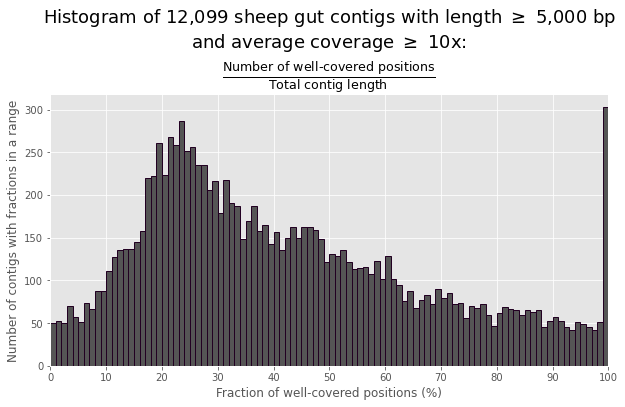

In [12]:
fracplot(
    e2wcfrac,
    r"Number\ of\ well" + u"\u2010" + r"covered\ positions",
    r"Total\ contig\ length",
    denclause=f"\nand average coverage $\geq$ {params.MIN_AVG_COV}x",
    xlabel="Fraction of well-covered positions (%)",
    figfilename="prokeuk_wcposfrac.png",
    bar_interior_color="#555555",
    #vlines=[(human_wc_frac, "Human genome contig (interior region)")],
    use_symlog=0
)

In [13]:
# Compute this fraction for the human genome blocks, ignoring first and last 20 blocks
blockidx2wcfrac = {i: human_contig_results["num_wc_pos"][i] / 50000 for i in range(inner_block_start_idx, inner_block_end_idx)}
print(f"Average WC position fraction from the {num_inner_blocks:,} blocks shown in this plot: {100 * mean(blockidx2wcfrac.values()):.2f}%")

Average WC position fraction from the 1,986 blocks shown in this plot: 76.27%


1,986 edges represented in this edge2frac object.
Max frac: 99.994 (edge 1497); min frac: 5.303999999999999 (edge 1436)
Top 10 edges: [475, 375, 304, 1839, 329, 162, 1602, 937, 790, 1497]
Bottom 10 edges: [1436, 1780, 1773, 1934, 1967, 1176, 777, 1781, 294, 240]


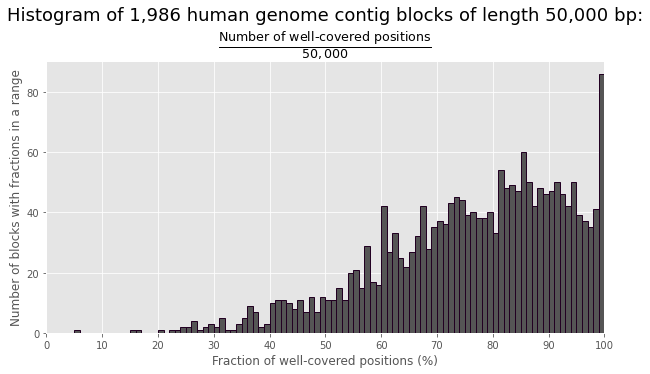

In [14]:
fracplot(
    blockidx2wcfrac,
    r"Number\ of\ well" + u"\u2010" + r"covered\ positions",
    r"50,000",
    noun="human genome contig blocks of length 50,000 bp",
    denclause="",
    xlabel="Fraction of well-covered positions (%)",
    ylabel="Number of blocks with fractions in a range",
    figfilename="prokeuk_wcposfrac_human.png",
    bar_interior_color="#555555",
    use_symlog=0
)

## Histograms of mutation frequencies (one histogram per contig)

### Human contig

In [17]:
h_mut_rates_alt_gt_min = []
for i in range(inner_block_start_idx, inner_block_end_idx):
    h_mut_rates_alt_gt_min += human_contig_results["alt_relfreqs"][i]
print(f"{len(h_mut_rates_alt_gt_min):,} positions will be represented in the mut freq histogram for the human contig.")

92,389 positions will be represented in the mut freq histogram for the human contig.


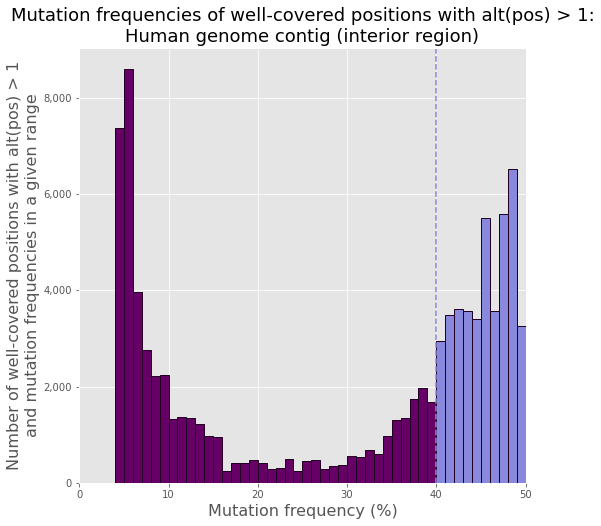

In [18]:
fig, ax = pyplot.subplots(1)

seq_mutrate_hist(ax, h_mut_rates_alt_gt_min, use_symlog=False)
ax.set_title(f"Mutation frequencies of well-covered positions with alt(pos) > 1:\nHuman genome contig (interior region)", fontsize=18)
ax.set_xlabel("Mutation frequency (%)", fontsize=16)
ax.set_ylabel(f"Number of well-covered positions with alt(pos) > 1\nand mutation frequencies in a given range", fontsize=16)

fig.set_size_inches(8, 8)
fig.savefig("figs/prokeuk_hcontig_mutrate_histogram.png", bbox_inches="tight")

### Sheep gut contigs

In [19]:
# Three selected bacterial MAGs used in the rare mutation report, plus two edges with low (or zero) fractions
#probs_prok_seqs_to_check = ["edge_6104", "edge_1671", "edge_2358", "edge_8", "edge_5763"]
probs_prok_seqs_to_check = ["edge_1", "edge_8", "edge_5763", "edge_25347", "edge_75990"]
# Some edges with esp high fractions
probs_euk_seqs_to_check = ["edge_4371", "edge_26085", "edge_32274", "edge_38957", "edge_78779"]

In [20]:
def get_seq2mincov_pos_mutation_rates(seqs_to_check):
    bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam")

    seq2mincov_pos_mutation_rates = {}
    for seq in seqs_to_check:
        contig_results = process_contig(
            "../main-workflow/output/all_edges.fasta",
            bf,
            seq,
            edge2len[seq],
            params.MIN_AVG_COV,
            params.MIN_ALT_POS,
            params.WELL_COVERED_POS_DEVIATION,
            params.WELL_COVERED_POS_DEVIATION / 100,
            # The numerator / denominator stuff doesn't really matter here, since we're just extracting the
            # alt relfreqs. We thus keep them the same as the defaults for the sake of simplicity.
            params.MIN_NUMERATOR_ALT_RELFREQ / 100,
            params.MIN_DENOMINATOR_ALT_RELFREQ / 100,
            params.MAX_NUMERATOR_ALT_RELFREQ / 100,
            params.MAX_DENOMINATOR_ALT_RELFREQ / 100,
            False,
            params.PYSAM_MAX_DEPTH,
            verbose=True,
            extra_verbose=True
        )
        seq2mincov_pos_mutation_rates[seq] = contig_results["alt_relfreqs"]
        print(f"Computed info for seq {seq}!")
    bf.close()
    return seq2mincov_pos_mutation_rates

In [21]:
seq2mincov_pos_mutation_rates_ten = get_seq2mincov_pos_mutation_rates(
    probs_euk_seqs_to_check + probs_prok_seqs_to_check
)

Starting process_contig() for contig edge_4371 (length 1,389,684 bp).
Just processed position 100,000 / 1,389,684 (7.20%).
Just processed position 200,000 / 1,389,684 (14.39%).
Just processed position 300,000 / 1,389,684 (21.59%).
Just processed position 400,000 / 1,389,684 (28.78%).
Just processed position 500,000 / 1,389,684 (35.98%).
Just processed position 600,000 / 1,389,684 (43.18%).
Just processed position 700,000 / 1,389,684 (50.37%).
Just processed position 800,000 / 1,389,684 (57.57%).
Just processed position 900,000 / 1,389,684 (64.76%).
Just processed position 1,000,000 / 1,389,684 (71.96%).
Just processed position 1,100,000 / 1,389,684 (79.15%).
Just processed position 1,200,000 / 1,389,684 (86.35%).
Just processed position 1,300,000 / 1,389,684 (93.55%).
    Average coverage: 12.17x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [9.73x, 14.60x] are WC.
    406,357 / 1,389,684 (29.24%) positions in this contig are WC.
    2,325 WC numerator p

#### Save this JSON data to a new file / Load it from that file so we can avoid redoing the above step if needed

(...because this data takes like 30 minutes to generate, and I don't want to have to melt an iceberg every time I want to change a color in one of these plots...)

In [22]:
with open("misc-output/seq2mincov_pos_mutation_rates.json", "w") as jf:
    jf.write(json.dumps(seq2mincov_pos_mutation_rates_ten))

In [23]:
with open("misc-output/seq2mincov_pos_mutation_rates.json", "r") as jf:
    seq2mincov_pos_mutation_rates_ten = json.load(jf)

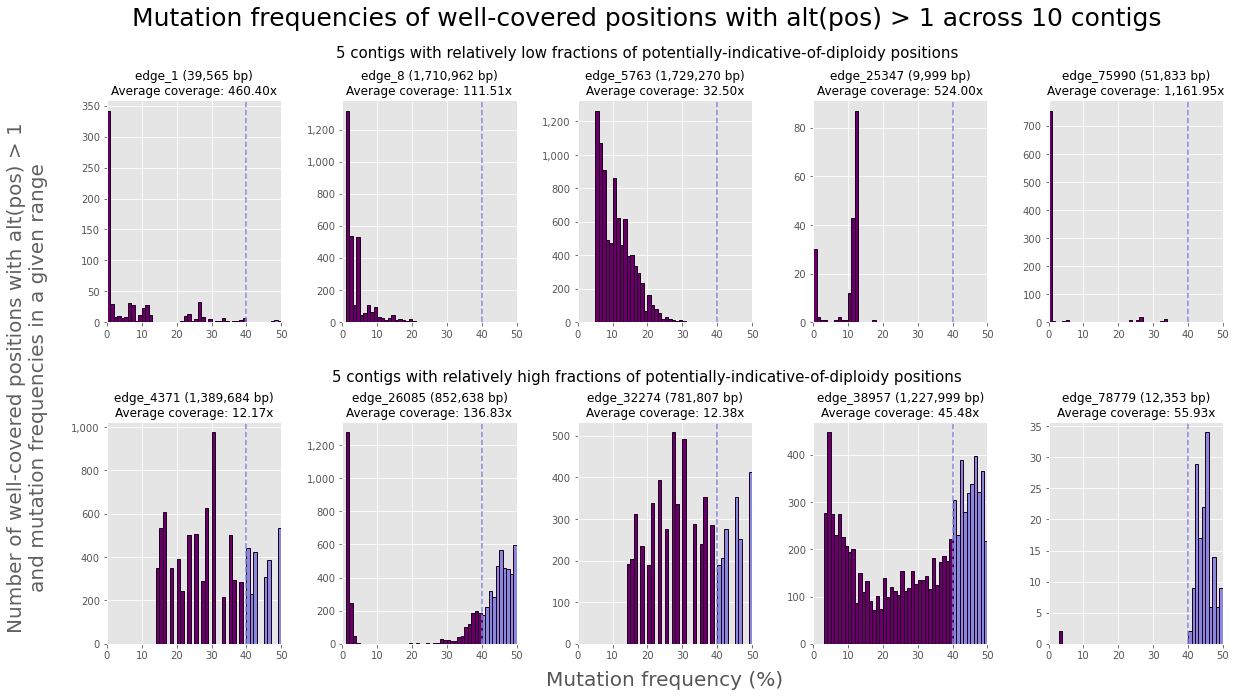

In [24]:
fig, axes = pyplot.subplots(2, 5, gridspec_kw={"wspace": 0.35, "hspace": 0.45})

rows = [probs_prok_seqs_to_check, probs_euk_seqs_to_check]
for ri, row in enumerate(rows):
    for ci, seq in enumerate(row):
        mut_rates = seq2mincov_pos_mutation_rates_ten[seq]
        seq_mutrate_hist(axes[ri, ci], mut_rates, use_symlog=False)
        axes[ri, ci].set_title(f"{seq} ({edge2len[seq]:,} bp)\nAverage coverage: {edge2meancov[seq]:,.2f}x", fontsize=12)

axes[1, 2].set_xlabel("Mutation frequency (%)", fontsize=20, labelpad=10)
        
num_plotted_edges = sum([len(r) for r in rows])
# We move up the suptitle's y from 0.98 (default) as a very crude way to force the plot to have
# more space between this title and the row 1 title.
fig.suptitle(
    f"Mutation frequencies of well-covered positions with alt(pos) > 1 across {num_plotted_edges} contigs",
    y=1.01,
    fontsize=25
)

# y-axis label: centered on the left side of the figure
fig.text(
    0.07, 0.495,
    f"Number of well-covered positions with alt(pos) > 1\nand mutation frequencies in a given range",
    color="#606060",
    fontsize=20,
    rotation=90,
    va="center",
    ha="center"
)
# Title for row 1. The y-value here is because this is figure coordinates, so this is "close to the top
# of the plot".
fig.text(
    0.5, 0.945,
    '5 contigs with relatively low fractions of potentially-indicative-of-diploidy positions',
    fontsize=15,
    ha="center",
    va="center"
)
# Title for row 2.
fig.text(
    0.5, 0.495,
    '5 contigs with relatively high fractions of potentially-indicative-of-diploidy positions',
    fontsize=15,
    ha="center",
    va="center"
)
fig.set_size_inches(20, 10)
fig.savefig("figs/prokeuk_10_mutrate_histograms.png", bbox_inches="tight")

In [25]:
def big_mr_plot(sorted_df, high_ratio_contigs, seq2mrs, L, figfilename,
                x2vlinecolor={20: "#660066", 40: "#8888dd"},
                num_range="[40%, 50%]", den_range="[20%, 40%)"):
    
    num_plotted_edges = L * L
    fig, axes = pyplot.subplots(L, L, gridspec_kw={"wspace": 0.35, "hspace": 0.6})

    for si, seq in enumerate(high_ratio_contigs[:num_plotted_edges]):
        ri = math.floor(si / L)
        ci = si % L
        mut_rates = seq2mrs[seq]
        seq_mutrate_hist(
            axes[ri, ci], mut_rates, use_symlog=False, x2vlinecolor=x2vlinecolor
        )

        # Lots of these ratios will be integers (i.e. numerator is divisible by denominator), and in these cases
        # we wanna avoid unneeded trailing zeroes. But this is not guaranteed to be the case.
        # Lots of hacks we could use here (see answers to https://stackoverflow.com/q/2440692), but we just
        # do something silly -- we have access to both the numerator and denominator of the ratio, so we can
        # show it as an integer if num % den == 0 (i.e. there's no stuff after the decimal point) and otherwise
        # use two digits.
        num = sorted_df['NumWellCoveredNumeratorPositions'][seq]
        den = sorted_df['NumWellCoveredDenominatorPositions'][seq]
        frac = sorted_df['DiploidFraction'][seq]
        if num % den == 0:
            sfrac = f"{frac:,.0f}"
        else:
            sfrac = f"{frac:,.2f}"
        axes[ri, ci].set_title(
            (
                f"{seq} ({edge2len[seq]:,} bp)\n"
                f"Average coverage: {edge2meancov[seq]:,.2f}x\n"
                f"Ratio: {num:,} / {den:,}"
                r" = "
                f"{sfrac}"
            ), fontsize=11)

    axes[L - 1, round(L / 2)].set_xlabel("Mutation frequency (%)", fontsize=20, labelpad=10)
    fig.suptitle(
        (
            f"Mutation frequencies of well-covered positions with alt(pos) > 1 across {num_plotted_edges} contigs,\n"
            f"limited to contigs with average coverage "
            r"$\geq$ 100x and $\geq$ 100 numerator positions:"
            f"\nsorted in descending order by the ratio of {num_range} mutations to {den_range} mutations\n"
        ),
        y=0.97,
        x=0.51,
        fontsize=32
    )

    # y-axis label: centered on the left side of the figure
    fig.text(
        0.09, 0.495,
        f"Number of well-covered positions with alt(pos) > 1\nand mutation frequencies in a given range",
        color="#606060",
        fontsize=20,
        rotation=90,
        va="center",
        ha="center"
    )
    fig.set_size_inches(30, 30)
    fig.savefig(f"figs/{figfilename}", bbox_inches="tight")

#### Contigs with high ratios of $[40\%, 50\%]$ positions to $[20\%, 40\%)$ positions

In [170]:
df = pd.read_csv("../../prok-euk-analyses/output/pleuk_diff_ratio_frac_info.tsv", sep="\t", index_col=0)
df_f = df.loc[df["AverageCoverage"] >= 100]
df_f2 = df_f.loc[df_f["NumWellCoveredNumeratorPositions"] >= 100]
sdf = df_f2.sort_values(by="DiploidFraction", ascending=False)
high_ratio_contigs = sdf.index[:100]

In [171]:
seq2mincov_pos_mutation_rates_ratiohigh = get_seq2mincov_pos_mutation_rates(
    high_ratio_contigs
)

Starting process_contig() for contig edge_75639.
    Average coverage: 156.07x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [124.86x, 187.29x] are WC.
    71,529 / 82,340 (86.87%) positions in this contig are WC.
    700 WC numerator pos; 701 WC denominator pos.
Computed info for seq edge_75639!
Starting process_contig() for contig edge_77690.
    Average coverage: 132.41x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [105.93x, 158.90x] are WC.
    35,411 / 35,534 (99.65%) positions in this contig are WC.
    320 WC numerator pos; 324 WC denominator pos.
Computed info for seq edge_77690!
Starting process_contig() for contig edge_55681.
    Average coverage: 208.27x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [166.62x, 249.93x] are WC.
    22,690 / 22,711 (99.91%) positions in this contig are WC.
    463 WC numerator pos; 497 WC denominator pos.
Computed info for seq edge_55681!
Starting p

Just processed position 100,000 / 208,983 (47.85%).
Just processed position 200,000 / 208,983 (95.70%).
    Average coverage: 346.08x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [276.86x, 415.29x] are WC.
    180,280 / 208,983 (86.27%) positions in this contig are WC.
    992 WC numerator pos; 1,373 WC denominator pos.
Computed info for seq edge_63481!
Starting process_contig() for contig edge_69541.
Just processed position 100,000 / 215,248 (46.46%).
Just processed position 200,000 / 215,248 (92.92%).
    Average coverage: 353.39x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [282.71x, 424.07x] are WC.
    194,406 / 215,248 (90.32%) positions in this contig are WC.
    1,305 WC numerator pos; 2,095 WC denominator pos.
Computed info for seq edge_69541!
Starting process_contig() for contig edge_26085.
Just processed position 100,000 / 852,638 (11.73%).
Just processed position 200,000 / 852,638 (23.46%).
Just processed pos

Just processed position 100,000 / 134,528 (74.33%).
    Average coverage: 146.48x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [117.18x, 175.77x] are WC.
    94,321 / 134,528 (70.11%) positions in this contig are WC.
    1,025 WC numerator pos; 1,758 WC denominator pos.
Computed info for seq edge_37608!
Starting process_contig() for contig edge_74412.
    Average coverage: 100.25x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [80.20x, 120.29x] are WC.
    30,149 / 30,149 (100.00%) positions in this contig are WC.
    199 WC numerator pos; 297 WC denominator pos.
Computed info for seq edge_74412!
Starting process_contig() for contig edge_31746.
Just processed position 100,000 / 115,265 (86.76%).
    Average coverage: 357.05x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [285.64x, 428.46x] are WC.
    94,795 / 115,265 (82.24%) positions in this contig are WC.
    161 WC numerator pos; 460 WC 

    Average coverage: 131.91x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [105.53x, 158.29x] are WC.
    19,611 / 84,083 (23.32%) positions in this contig are WC.
    131 WC numerator pos; 387 WC denominator pos.
Computed info for seq edge_63097!
Starting process_contig() for contig edge_46876.
Just processed position 100,000 / 242,802 (41.19%).
Just processed position 200,000 / 242,802 (82.37%).
    Average coverage: 188.86x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [151.09x, 226.64x] are WC.
    63,443 / 242,802 (26.13%) positions in this contig are WC.
    337 WC numerator pos; 954 WC denominator pos.
Computed info for seq edge_46876!
Starting process_contig() for contig edge_844.
Just processed position 100,000 / 295,465 (33.84%).
Just processed position 200,000 / 295,465 (67.69%).
    Average coverage: 194.74x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [155.79x, 233.69x] are WC

Just processed position 100,000 / 108,489 (92.18%).
    Average coverage: 124.57x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [99.66x, 149.49x] are WC.
    80,339 / 108,489 (74.05%) positions in this contig are WC.
    221 WC numerator pos; 456 WC denominator pos.
Computed info for seq edge_4449!
Starting process_contig() for contig edge_5960.
    Average coverage: 508.69x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [406.95x, 610.43x] are WC.
    11,156 / 46,407 (24.04%) positions in this contig are WC.
    134 WC numerator pos; 308 WC denominator pos.
Computed info for seq edge_5960!
Starting process_contig() for contig edge_40103.
    Average coverage: 128.69x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [102.95x, 154.43x] are WC.
    34,382 / 34,400 (99.95%) positions in this contig are WC.
    131 WC numerator pos; 303 WC denominator pos.
Computed info for seq edge_40103!
Starting p

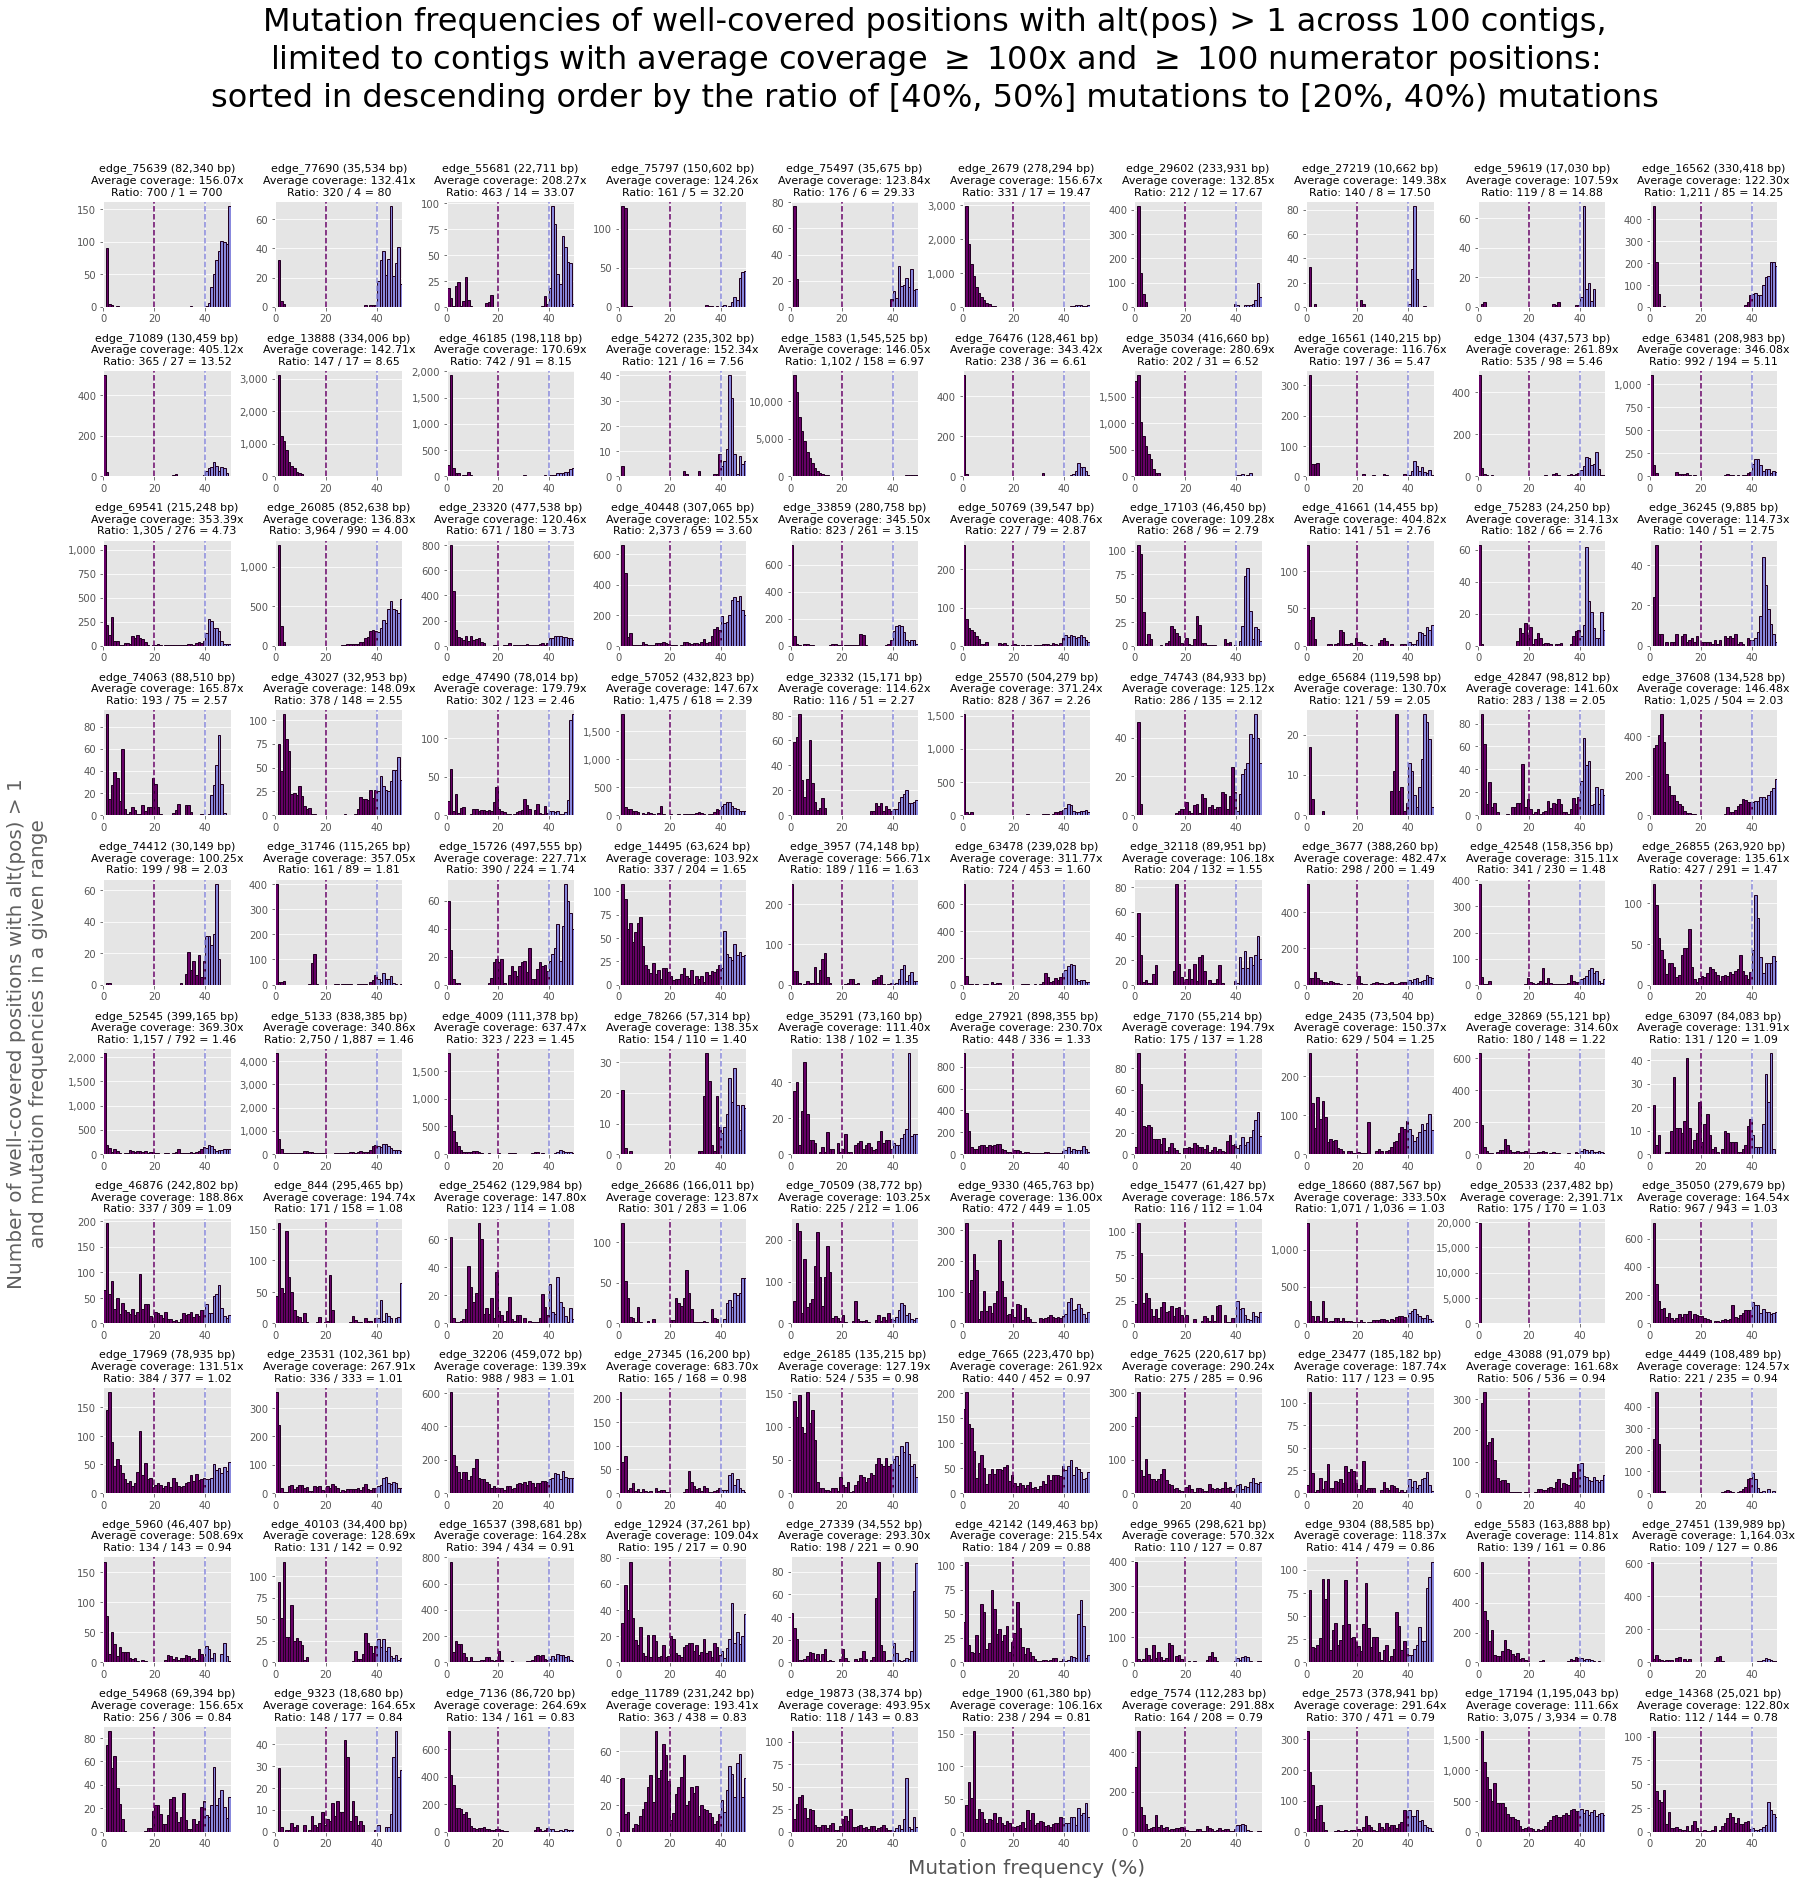

In [174]:
big_mr_plot(sdf, high_ratio_contigs, seq2mincov_pos_mutation_rates_ratiohigh, 10,
            figfilename="40_50_to_20_40_top100.png")

#### Contigs with high fractions of $[40\%, 50\%]$ positions to $[10\%, 50\%]$ positions

... aka the ordinary diploid fraction

In [177]:
df_ordinary = pd.read_csv("../../prok-euk-analyses/output/pleuk_frac_info.tsv", sep="\t", index_col=0)
df_ordinary_f = df_ordinary.loc[df_ordinary["AverageCoverage"] >= 100]
df_ordinary_f2 = df_ordinary_f.loc[df_ordinary_f["NumWellCoveredNumeratorPositions"] >= 100]
sdf_ordinary = df_ordinary_f2.sort_values(by=["DiploidFraction"], ascending=False)
high_ratio_contigs_ordinary = sdf_ordinary.index[:100]

In [178]:
seq2mincov_pos_mutation_rates_ratiohigh_ordinary = get_seq2mincov_pos_mutation_rates(
    high_ratio_contigs_ordinary
)

Starting process_contig() for contig edge_74960.
    Average coverage: 140.80x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [112.64x, 168.96x] are WC.
    39,037 / 39,091 (99.86%) positions in this contig are WC.
    146 WC numerator pos; 146 WC denominator pos.
Computed info for seq edge_74960!
Starting process_contig() for contig edge_17625.
    Average coverage: 142.06x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [113.65x, 170.47x] are WC.
    19,715 / 24,785 (79.54%) positions in this contig are WC.
    119 WC numerator pos; 119 WC denominator pos.
Computed info for seq edge_17625!
Starting process_contig() for contig edge_36709.
    Average coverage: 137.66x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [110.13x, 165.20x] are WC.
    53,872 / 60,222 (89.46%) positions in this contig are WC.
    174 WC numerator pos; 174 WC denominator pos.
Computed info for seq edge_36709!
Starting p

Just processed position 500,000 / 852,638 (58.64%).
Just processed position 600,000 / 852,638 (70.37%).
Just processed position 700,000 / 852,638 (82.10%).
Just processed position 800,000 / 852,638 (93.83%).
    Average coverage: 136.83x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [109.46x, 164.19x] are WC.
    608,672 / 852,638 (71.39%) positions in this contig are WC.
    3,964 WC numerator pos; 4,956 WC denominator pos.
Computed info for seq edge_26085!
Starting process_contig() for contig edge_40448.
Just processed position 100,000 / 307,065 (32.57%).
Just processed position 200,000 / 307,065 (65.13%).
Just processed position 300,000 / 307,065 (97.70%).
    Average coverage: 102.55x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [82.04x, 123.06x] are WC.
    249,483 / 307,065 (81.25%) positions in this contig are WC.
    2,373 WC numerator pos; 3,176 WC denominator pos.
Computed info for seq edge_40448!
Starting proce

Just processed position 400,000 / 432,823 (92.42%).
    Average coverage: 147.67x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [118.13x, 177.20x] are WC.
    211,348 / 432,823 (48.83%) positions in this contig are WC.
    1,475 WC numerator pos; 2,497 WC denominator pos.
Computed info for seq edge_57052!
Starting process_contig() for contig edge_32332.
    Average coverage: 114.62x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [91.69x, 137.54x] are WC.
    15,051 / 15,171 (99.21%) positions in this contig are WC.
    116 WC numerator pos; 197 WC denominator pos.
Computed info for seq edge_32332!
Starting process_contig() for contig edge_78266.
    Average coverage: 138.35x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [110.68x, 166.02x] are WC.
    28,112 / 57,314 (49.05%) positions in this contig are WC.
    154 WC numerator pos; 264 WC denominator pos.
Computed info for seq edge_78266!
St

    Average coverage: 161.68x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [129.34x, 194.01x] are WC.
    68,594 / 91,079 (75.31%) positions in this contig are WC.
    506 WC numerator pos; 1,138 WC denominator pos.
Computed info for seq edge_43088!
Starting process_contig() for contig edge_26855.
Just processed position 100,000 / 263,920 (37.89%).
Just processed position 200,000 / 263,920 (75.78%).
    Average coverage: 135.61x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [108.49x, 162.73x] are WC.
    38,039 / 263,920 (14.41%) positions in this contig are WC.
    427 WC numerator pos; 974 WC denominator pos.
Computed info for seq edge_26855!
Starting process_contig() for contig edge_27339.
    Average coverage: 293.30x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [234.64x, 351.95x] are WC.
    5,108 / 34,552 (14.78%) positions in this contig are WC.
    198 WC numerator pos; 453 WC deno

    Average coverage: 188.86x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [151.09x, 226.64x] are WC.
    63,443 / 242,802 (26.13%) positions in this contig are WC.
    337 WC numerator pos; 954 WC denominator pos.
Computed info for seq edge_46876!
Starting process_contig() for contig edge_32206.
Just processed position 100,000 / 459,072 (21.78%).
Just processed position 200,000 / 459,072 (43.57%).
Just processed position 300,000 / 459,072 (65.35%).
Just processed position 400,000 / 459,072 (87.13%).
    Average coverage: 139.39x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [111.51x, 167.27x] are WC.
    163,147 / 459,072 (35.54%) positions in this contig are WC.
    988 WC numerator pos; 2,799 WC denominator pos.
Computed info for seq edge_32206!
Starting process_contig() for contig edge_31746.
Just processed position 100,000 / 115,265 (86.76%).
    Average coverage: 357.05x. Meets the mininum of 10.00x.
    Deviation i

Just processed position 100,000 / 264,296 (37.84%).
Just processed position 200,000 / 264,296 (75.67%).
    Average coverage: 157.06x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [125.65x, 188.47x] are WC.
    166,734 / 264,296 (63.09%) positions in this contig are WC.
    693 WC numerator pos; 2,122 WC denominator pos.
Computed info for seq edge_12152!


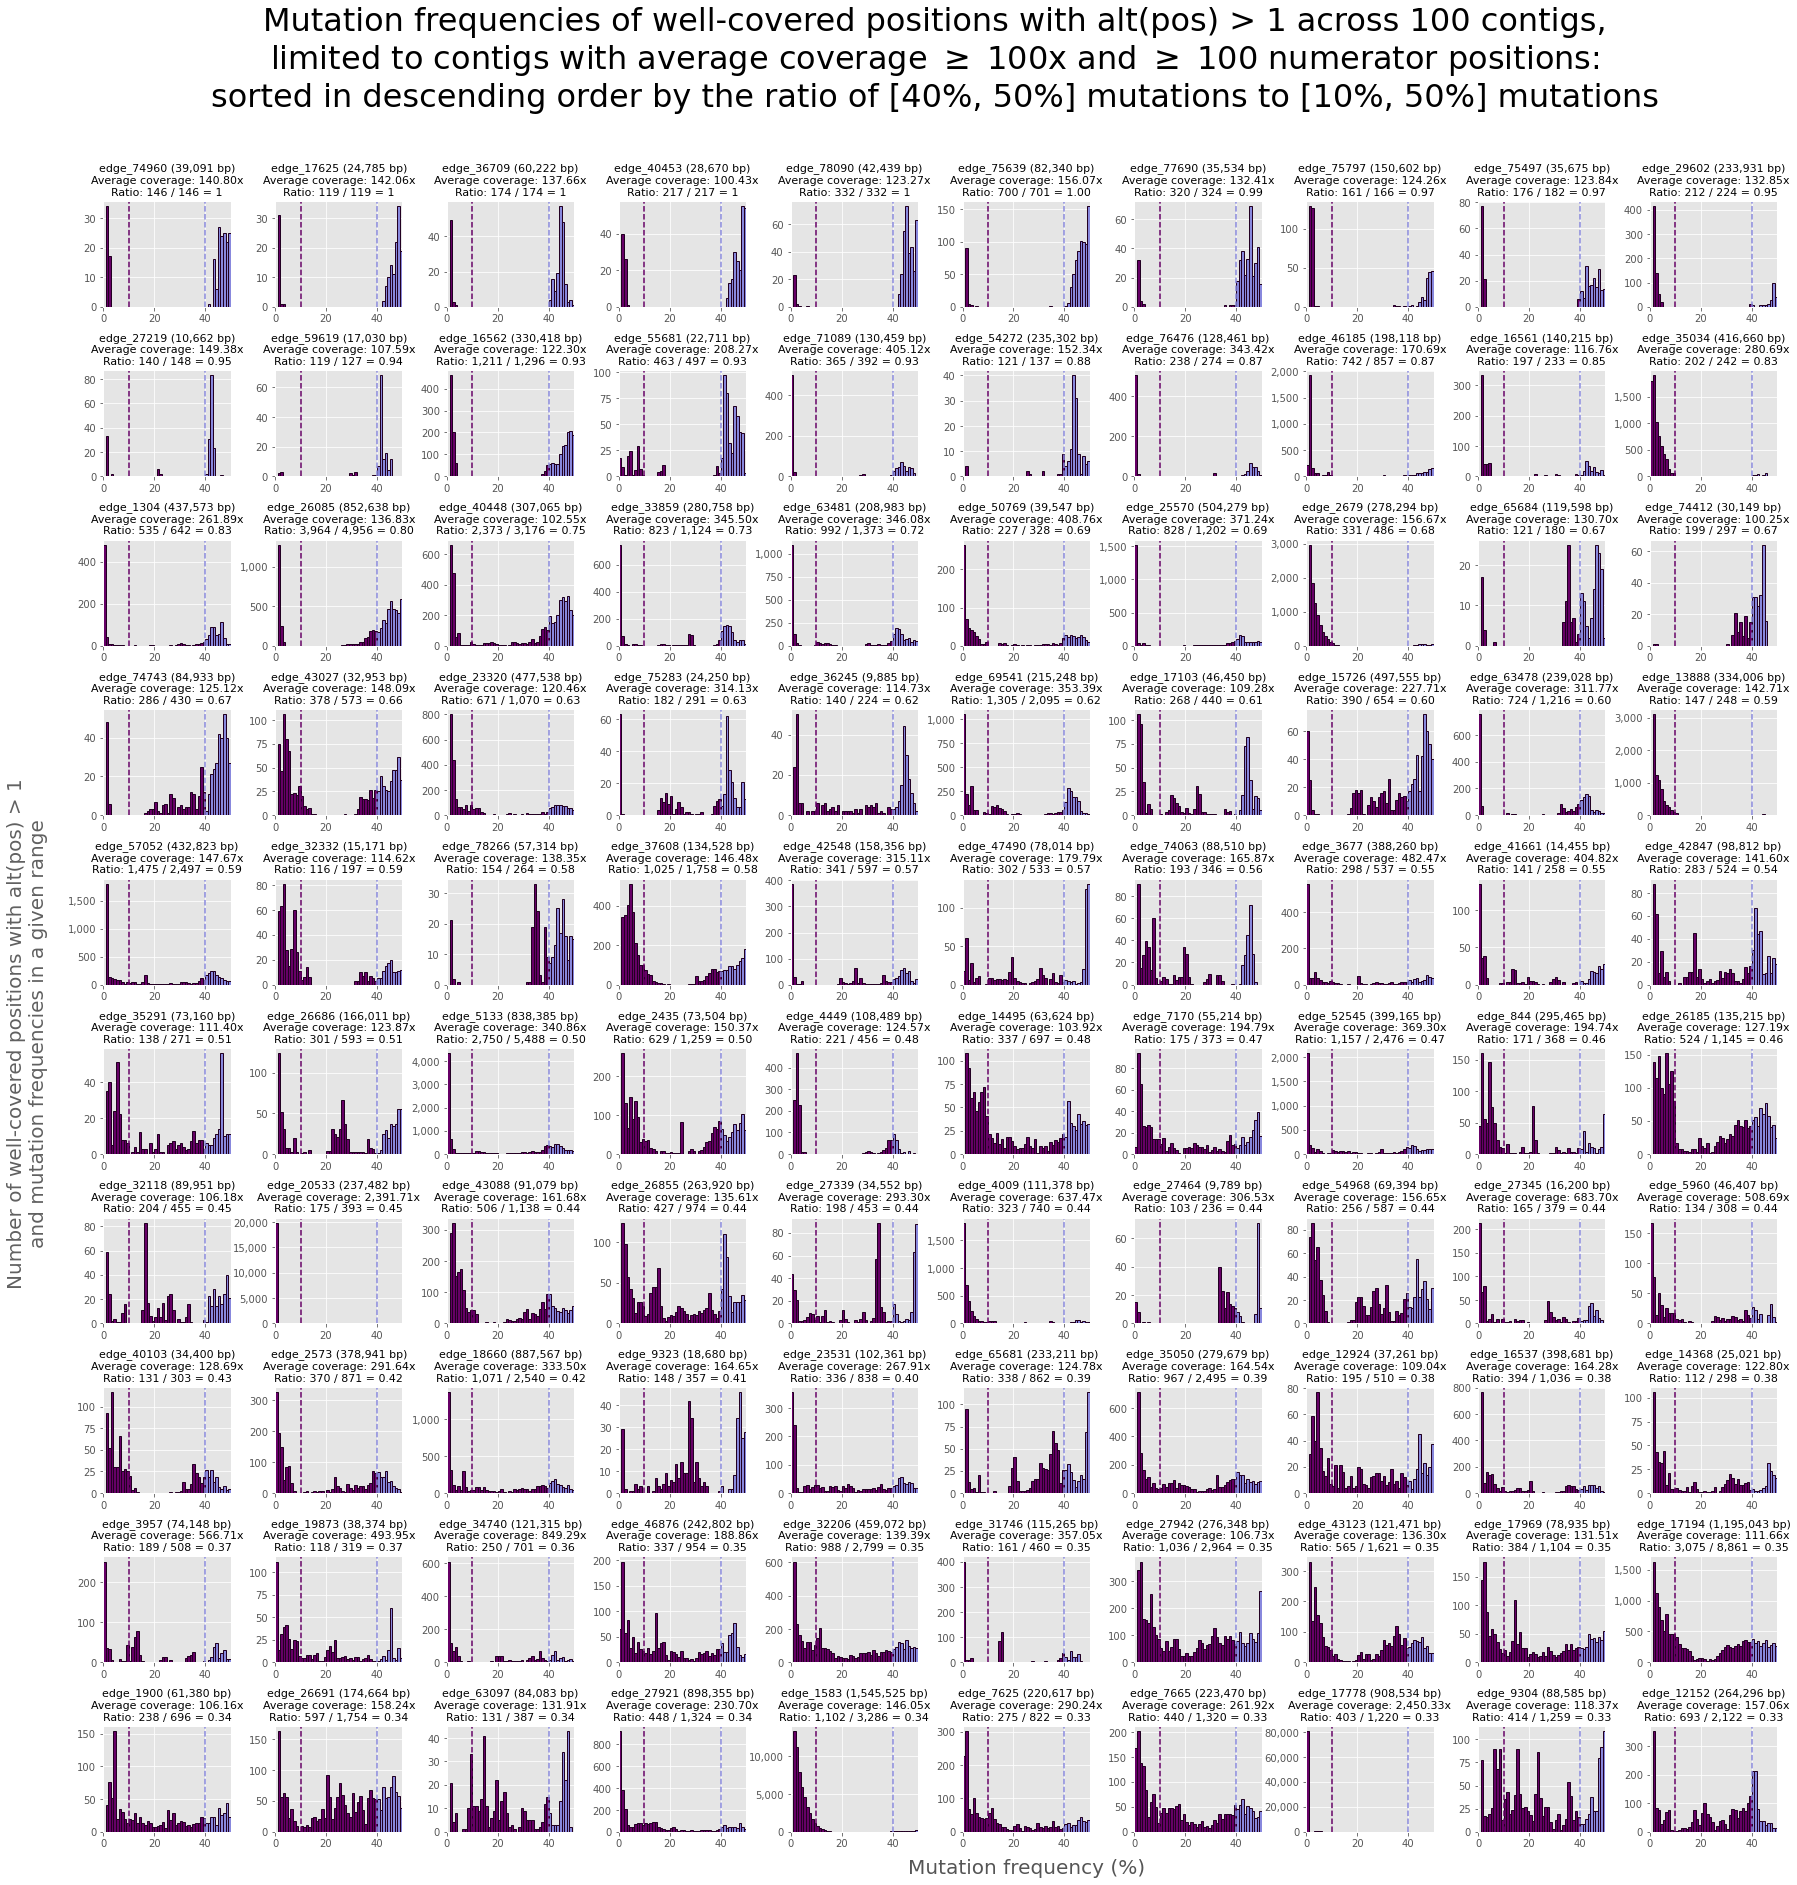

In [179]:
big_mr_plot(sdf_ordinary, high_ratio_contigs_ordinary, seq2mincov_pos_mutation_rates_ratiohigh_ordinary, 10,
            x2vlinecolor={10: "#660066", 40: "#8888dd"},
            den_range="[10%, 50%]",
            figfilename="40_50_to_10_50_top100.png")

## Visualize diploid fractions

In [29]:
# # we already filtered h_mut_rates_alt_gt_min to positions with alt(pos) > 1 so we can just look at rel frequencies
# human_diploid_ct = len([m for m in h_mut_rates_alt_gt_min if m >= params.MIN_NUMERATOR_ALT_RELFREQ])
# human_denominator_ct = len([m for m in h_mut_rates_alt_gt_min if m >= params.MIN_DENOMINATOR_ALT_RELFREQ])
# hfrac = human_diploid_ct / human_denominator_ct
# print(f"Human diploid fraction: {100 * hfrac:.2f}%")
# print(f"Number of diploid positions: {human_diploid_ct:,}")
# print(f"Number of denominator positions: {human_denominator_ct:,}")

In [30]:
def dfplot_sheepgut_contigs(min_denominator_val, use_symlog=True, figfilename=None, exclude_fracs_below=None):
    
    if min_denominator_val < 0:
        raise ValueError("Min denominator val has to be at least 0, otherwise we get division by 0 errors...")
    
    e2frac = {}
    for e in edge2num_wc_den_pos:
        if edge2num_wc_den_pos[e] > min_denominator_val:
            f = edge2num_wc_diploid_pos[e] / edge2num_wc_den_pos[e]
            if exclude_fracs_below is None or f >= exclude_fracs_below:
                e2frac[e] = f
    
    # We explicilty use the unicode character for the hyphen to prevent LaTeX from treating it as a
    # minus symbol. This is a bit harder to handle simply in matplotlib-using-LaTeX than it is in just
    # vanilla LaTeX. Idea to use unicode chars c/o https://stackoverflow.com/a/30201951 (although I used
    # a different unicode character).
    prefix = r"Number\ of\ well" + u"\u2010" + r"covered\ positions\ with\ mutation\ frequencies\ \geq "
    denclause = ",\naverage coverage $\geq$ 10x, "
    dvc = f"a denominator > {min_denominator_val:,}"
    if exclude_fracs_below is None:
        denclause += f"and {dvc}"
    else:
        denclause += f"{dvc}, and fractions $\geq$ {exclude_fracs_below * 100:.0f}%"
    
    fracplot(
        e2frac,
        prefix + "40\%\ and\ alt(pos)\ > 1",
        prefix + "10\%\ and\ alt(pos)\ > 1",
        denclause=denclause,
        figfilename=figfilename,
        use_symlog=use_symlog,
        #vlines=[(hfrac, "Human genome contig (interior region)")]
    )

In [31]:
def dfplot_human_blocks(min_denominator_val, use_symlog=True, figfilename=None, exclude_fracs_below=None):
    # NOTE THAT min_denominator_val is not included, so i guess it should be + 1 or something in the future
    
    if min_denominator_val < 0:
        raise ValueError("Min denominator val has to be at least 0, otherwise we get division by 0 errors...")

    b2frac = {}
    for i in range(inner_block_start_idx, inner_block_end_idx):
        if human_contig_results["num_wc_denominator_pos"][i] > min_denominator_val:
            f = human_contig_results["num_wc_numerator_pos"][i] / human_contig_results["num_wc_denominator_pos"][i]
            if exclude_fracs_below is None or f >= exclude_fracs_below:
                b2frac[i] = f
                
    # This code is reused with the other dfplot_ method... try to limit reuse if easily possible
    prefix = r"Number\ of\ well" + u"\u2010" + r"covered\ positions\ with\ mutation\ frequencies\ \geq "
    denclause = " "
    dvc = f"a denominator > {min_denominator_val:,}"
    if exclude_fracs_below is None:
        denclause += f"and {dvc}"
    else:
        denclause += f"{dvc}, and fractions $\geq$ {exclude_fracs_below * 100:.0f}%"
    
    fracplot(
        b2frac,
        prefix + "40\%\ and\ alt(pos)\ > 1",
        prefix + "10\%\ and\ alt(pos)\ > 1",
        noun="human genome contig blocks\nof length 50,000 bp",
        ylabel="Number of blocks with fractions in a range",
        denclause=denclause,
        figfilename=figfilename,
        use_symlog=use_symlog,
    )

### All contigs with a nonzero denominator

8,523 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78793); min frac: 0.0 (edge edge_3)
Top 10 edges: ['edge_77463', 'edge_77680', 'edge_77713', 'edge_77866', 'edge_78010', 'edge_78042', 'edge_78090', 'edge_78642', 'edge_78779', 'edge_78793']
Bottom 10 edges: ['edge_3', 'edge_8', 'edge_17', 'edge_35', 'edge_37', 'edge_67', 'edge_72', 'edge_79', 'edge_81', 'edge_106']


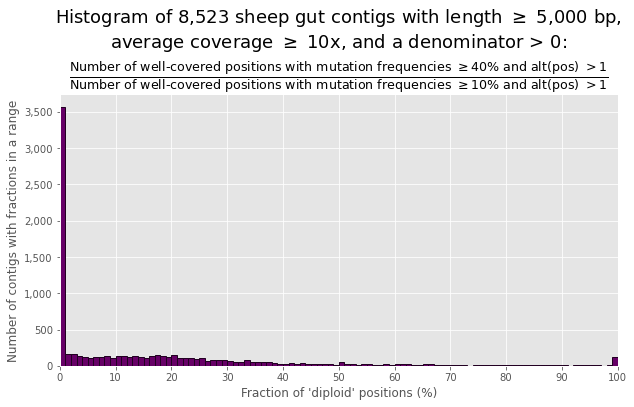

In [32]:
dfplot_sheepgut_contigs(0, use_symlog=False, figfilename="prokeukfrac_minden0_nonlog.png")

3,770 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78779); min frac: 1.015625 (edge edge_72658)
Top 10 edges: ['edge_75639', 'edge_17625', 'edge_18152', 'edge_20930', 'edge_36709', 'edge_40453', 'edge_74960', 'edge_76641', 'edge_78090', 'edge_78779']
Bottom 10 edges: ['edge_72658', 'edge_3158', 'edge_78631', 'edge_127', 'edge_13654', 'edge_76545', 'edge_28448', 'edge_63723', 'edge_3778', 'edge_22932']


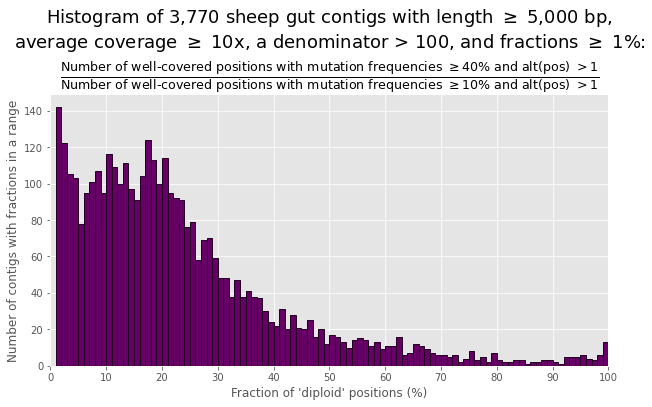

In [33]:
dfplot_sheepgut_contigs(100, use_symlog=False, exclude_fracs_below=0.01, figfilename="prokeukfrac_minden100_fgeq1.png")

8,523 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78793); min frac: 0.0 (edge edge_3)
Top 10 edges: ['edge_77463', 'edge_77680', 'edge_77713', 'edge_77866', 'edge_78010', 'edge_78042', 'edge_78090', 'edge_78642', 'edge_78779', 'edge_78793']
Bottom 10 edges: ['edge_3', 'edge_8', 'edge_17', 'edge_35', 'edge_37', 'edge_67', 'edge_72', 'edge_79', 'edge_81', 'edge_106']
5,226 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78779); min frac: 0.0 (edge edge_3)
Top 10 edges: ['edge_75639', 'edge_17625', 'edge_18152', 'edge_20930', 'edge_36709', 'edge_40453', 'edge_74960', 'edge_76641', 'edge_78090', 'edge_78779']
Bottom 10 edges: ['edge_3', 'edge_8', 'edge_17', 'edge_35', 'edge_37', 'edge_79', 'edge_106', 'edge_120', 'edge_430', 'edge_471']


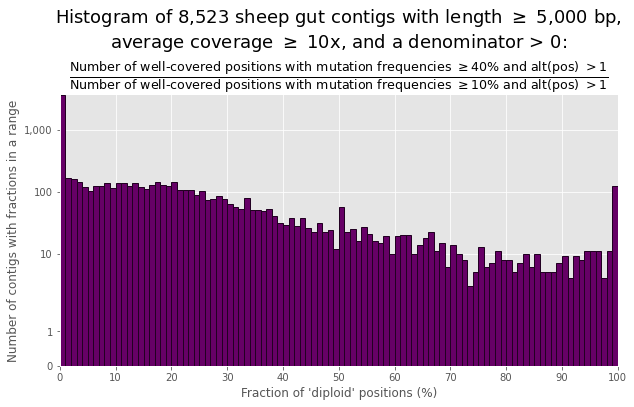

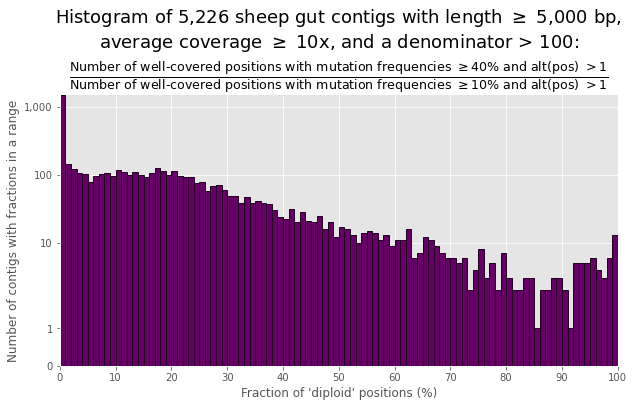

In [34]:
for minden in (0, 100):
    dfplot_sheepgut_contigs(minden, use_symlog=True, figfilename=f"prokeukfrac_minden{minden}.png")

1,910 edges represented in this edge2frac object.
Max frac: 100.0 (edge 1993); min frac: 0.0 (edge 21)
Top 10 edges: [1932, 1934, 1935, 1937, 1953, 1955, 1956, 1970, 1980, 1993]
Bottom 10 edges: [21, 22, 26, 28, 35, 38, 86, 126, 150, 177]
392 edges represented in this edge2frac object.
Max frac: 100.0 (edge 1572); min frac: 0.0 (edge 26)
Top 10 edges: [371, 508, 554, 720, 980, 1066, 1095, 1127, 1430, 1572]
Bottom 10 edges: [26, 38, 126, 968, 1566, 1415, 1905, 815, 432, 1132]
84 edges represented in this edge2frac object.
Max frac: 100.0 (edge 1095); min frac: 0.0 (edge 968)
Top 10 edges: [408, 142, 1568, 1632, 1292, 1574, 133, 154, 720, 1095]
Bottom 10 edges: [968, 1566, 1415, 1905, 815, 432, 1132, 575, 777, 1785]
36 edges represented in this edge2frac object.
Max frac: 97.6608187134503 (edge 1574); min frac: 0.0 (edge 968)
Top 10 edges: [1994, 604, 901, 792, 1573, 1496, 218, 2000, 1292, 1574]
Bottom 10 edges: [968, 1566, 1415, 1905, 1132, 1785, 332, 1614, 415, 557]


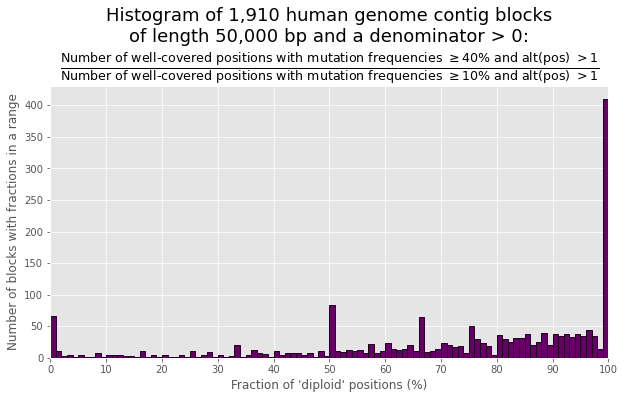

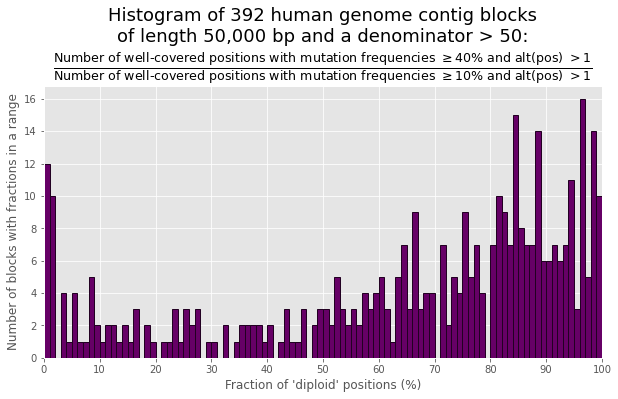

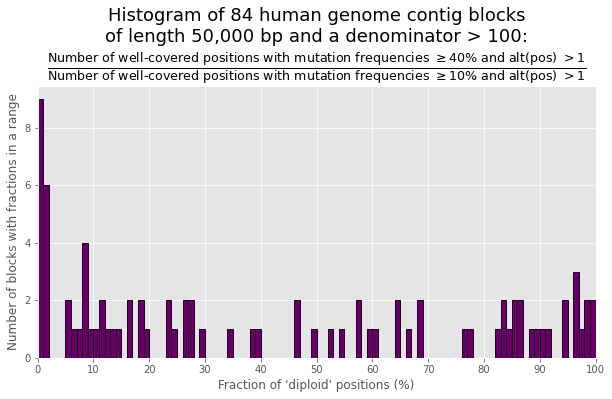

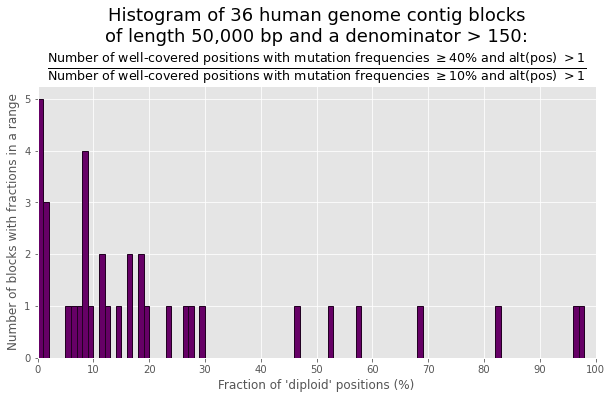

In [35]:
for minden in (0, 50, 100, 150):
    dfplot_human_blocks(minden, use_symlog=False, figfilename=f"prokeukfrac_humandiploidfractions_minden{minden}.png")

In [36]:
def estats(e):
    num_dip = edge2num_wc_diploid_pos[e]
    num_den = edge2num_wc_den_pos[e]
    num_mcp = edge2num_wc_pos[e]
    print(f"{e} ({edge2len[e]:,} bp long, {edge2meancov[e]:,.2f}x avg cov) has", end=" ")
    print(f"{num_mcp:,} WC pos.", end=" ")
    print(f"{num_dip:,} WC 'diploid' pos.", end=" ")
    print(f"{num_den:,} WC 'denominator' pos.")
    #if e in e2frac:
    #    print(f"\tDiploid fraction: {e2frac[e] * 100:.2f}%")
    #else:
    #    print("\tDiploid fraction undefined for this edge.")

In [37]:
estats("edge_78793")
estats("edge_5763")
estats("edge_78779")
estats("edge_26085")
estats("edge_38957")
estats("edge_32274")
estats("edge_4371")

edge_78793 (39,434 bp long, 29.65x avg cov) has 24,100 WC pos. 1 WC 'diploid' pos. 1 WC 'denominator' pos.
edge_5763 (1,729,270 bp long, 32.50x avg cov) has 1,144,224 WC pos. 0 WC 'diploid' pos. 4,799 WC 'denominator' pos.
edge_78779 (12,353 bp long, 55.93x avg cov) has 12,334 WC pos. 148 WC 'diploid' pos. 148 WC 'denominator' pos.
edge_26085 (852,638 bp long, 136.83x avg cov) has 608,672 WC pos. 3,964 WC 'diploid' pos. 4,956 WC 'denominator' pos.
edge_38957 (1,227,999 bp long, 45.48x avg cov) has 609,966 WC pos. 3,163 WC 'diploid' pos. 7,203 WC 'denominator' pos.
edge_32274 (781,807 bp long, 12.38x avg cov) has 225,344 WC pos. 1,691 WC 'diploid' pos. 6,334 WC 'denominator' pos.
edge_4371 (1,389,684 bp long, 12.17x avg cov) has 406,357 WC pos. 2,325 WC 'diploid' pos. 9,000 WC 'denominator' pos.
